In [1]:
import numpy as np
from heapq import *

In [2]:
def generate_matrix(k):
    n = 2 ** (3 * k)
    coeffs = np.random.random((n, n))
    matrix = np.zeros((n, n))
    
    row_length = 2 ** k
    neighbours = [-1, 1, row_length, -row_length, row_length ** 2, -(row_length ** 2)]
    
    for i in range(n):
        for neigh in neighbours:
            neight_id = i + neigh
            matrix[i, i] = 1
            if neight_id < 0 or neight_id >= n: 
                continue
                
            # Same row
            if neight_id // row_length == i // row_length:
                matrix[i, neight_id] = 1
            
            # Same column
            elif neight_id % row_length == i % row_length:
                matrix[i, neight_id] = 1
            
            # Same in third dimension
            else:
                matrix[i, neight_id] = 1
    
    matrix = matrix * coeffs
    return matrix

In [3]:
def graph(matrix):
    n = len(matrix)
    V = {}
    for i in range(n):
        V[i] = set()
        for j in range(n):
            if matrix[i, j] != 0:
                V[i].add(j)
    return V

def minimum_degree(matrix):
    # Create graph
    n = len(matrix)
    V = graph(matrix)
    
    pq = [(len(edge), v) for v, edge in V.items()]
    heapify(pq)
    visited = [False for i in range(n)]
    permutation = []
    
    while pq:
        _, v = heappop(pq)
        if visited[v]:
            continue
        
        visited[v] = True
        permutation.append(v)
        
        for edge in V[v]:
            if not visited[edge]:
                V[edge].remove(v)
                heappush(pq, (len(V[edge]), edge))
    
    return permutation  

In [4]:
m_test = np.array([[1, 1, 1, 1],
                  [1, 1, 0, 0],
                  [1, 0, 1, 1],
                  [1, 0, 1, 1]])
# answer: [1, 0, 2, 3] is acceptable
print(minimum_degree(m_test))


[1, 0, 2, 3]


In [6]:
def cuthill_mckee(matrix):
    n = len(matrix)
    V = graph(matrix) # No need to sort because I use heapque
    
    
    all_vertex = [(-len(edge), v) for v, edge in V.items()] # reverse heap
    heapify(all_vertex)
    
    bfs_pq = [all_vertex[0]]
    visited = [False for i in range(n)]
    
    permutation = []
    while bfs_pq:
        
        # If graph is no consistent - bfs_pq empty but not all vertex visited
        while not bfs_pq and all_vertex:
            _, u = heappop(all_vertex)
            if not visited[u]: heappush(bfs_pq, (-len(V[u]), u))
            
        
        _, v = heappop(bfs_pq)
        
        if visited[v]:
            continue
        
        visited[v] = True
        permutation.append(v)
        
        for edge in V[v]:
            if not visited[edge]:
                heappush(bfs_pq, (-len(V[edge]), edge))
    
    return permutation

In [7]:
# Z wykladu
test2 = np.array([[1, 1, 1, 1, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 0, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 0, 0, 0, 0],
                  [0, 0, 0, 1, 1, 1, 0, 0, 0],
                  [0, 0, 0, 0,1, 1, 1, 1, 1],
                  [0, 0, 0, 0, 0, 1, 1, 1, 1],
                  [0, 0, 0, 0, 0, 1, 1, 1, 1],
                  [0, 0, 0, 0, 0, 1, 1, 1, 1]])

cuthill_mckee(test2) # Działa

[3, 0, 1, 2, 4, 5, 6, 7, 8]

In [8]:
def reversed_cuthill_mckee(matrix):
    return list(reversed(cuthill_mckee(matrix)))

In [9]:
def permutate(matrix, p_table):
    return matrix[p_table, :]

### z lab 3

In [26]:
import numpy as np
import scipy.sparse as sp
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt

class CompressNode:
    def __init__(self, rank=0, children=None, singular_values=None, U=None, V=None, size=None):
        self.rank = rank
        self.children = children
        self.s = singular_values
        self.U = U
        self.V = V
        self.size = size
        self.val = None
        
    def append_child(self, child):
        self.children.append(child)
    
    def __str__(self):
        return f'Node: rank = {self.rank}; children: {self.children}; s: {self.s}; U = {self.U}; V = {self.V}, size = {self.size}'
    

def compress_matrix(matrix, U, s, V, r):
    node = None
    if (matrix == 0).all():
        node = CompressNode(rank=0, size=matrix.shape)
    
    else:
        D = np.diag(s)
        node = CompressNode(rank=r, singular_values=s[:r], U=U[:, :r], V=D[:r, :r] @ V[:r, ], 
                            size=matrix.shape)
    
    return node

def create_tree(matrix, r, epsilon):
    U, s, V = randomized_svd(matrix, n_components=r)
    r = s.size
    node = None
    if s[-1] < epsilon:
        node = compress_matrix(matrix, U, s, V, r)
    
    else:
        Y, X = matrix.shape
        
        if Y == X == 1:
            node = CompressNode(rank=1, size=(1, 1))
            node.val = matrix
            return node
        
        node = CompressNode(rank=r, children=[], size=(Y, X))
        
        # 4 childrens
        
        node.append_child(create_tree(matrix[0: Y // 2, 0: X // 2], r, epsilon))
        node.append_child(create_tree(matrix[0: Y // 2, X // 2: X], r, epsilon))
        node.append_child(create_tree(matrix[Y // 2: Y, 0: X // 2], r, epsilon))
        node.append_child(create_tree(matrix[Y // 2: Y, X // 2: X], r, epsilon))
        
    return node

def _canvas_matrix(root, x, y, n): #n must be 2^i where i is natural number
    if root.U is None and root.V is None and root.rank == 0: # Only zeros
        return
    
    elif root.children is None: # Leaf
        if root.val is not None: # Leaf
            plt.scatter(x, y, color="red", s=0.1)
            return
        else:
            xe = x + root.size[1]
            ye = y + root.size[0]
            plt.plot([x, xe], [y, y], color="black", lw=root.rank)
            plt.plot([x, x], [y, ye], color="black", lw=root.rank)
            return
    
    else:
        childs = root.children
        n = n//2
        _canvas_matrix(childs[0], x, y + n, n)
        _canvas_matrix(childs[1], x + n, y + n, n)
        _canvas_matrix(childs[2], x, y, n)
        _canvas_matrix(childs[3], x + n, y, n)
        return

def wisualize_svd(matrix_tree: CompressNode, n):
    _canvas_matrix(matrix_tree, 0,0, n)

## Raport
2 podpunkt

In [45]:
import matplotlib.pyplot as plt

k = 2
matrix = generate_matrix(k)


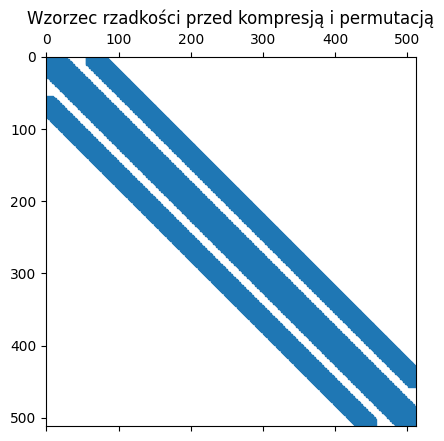

In [46]:
plt.spy(matrix, markersize=10)
plt.title("Wzorzec rzadkości przed kompresją i permutacją")
plt.show()

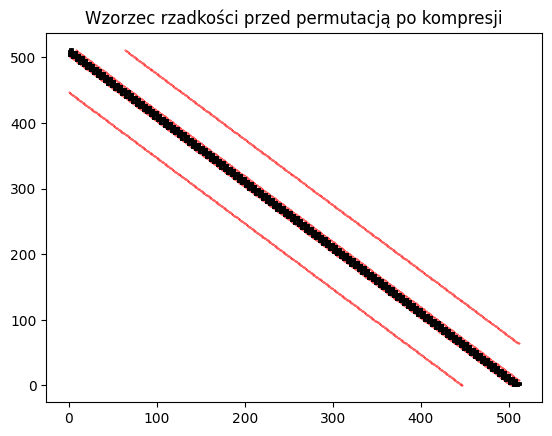

In [47]:
n = len(matrix)
tree = create_tree(matrix, 2, 10**-12)
wisualize_svd(tree, n)
plt.title("Wzorzec rzadkości przed permutacją po kompresji")
plt.show()

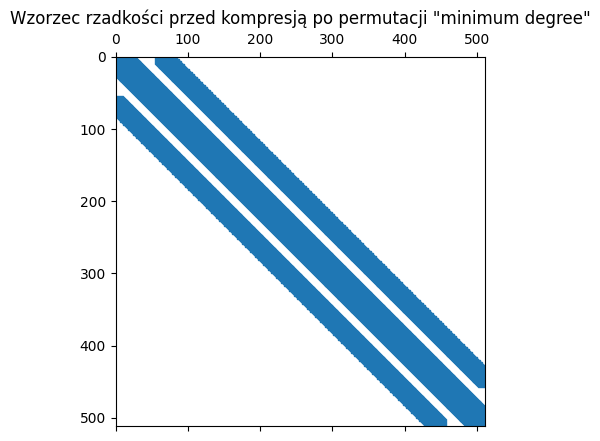

In [48]:
permutate_matrix_md = matrix[minimum_degree(matrix)]
plt.spy(permutate_matrix_md, markersize=10)
plt.title("Wzorzec rzadkości przed kompresją po permutacji \"minimum degree\"")
plt.show()

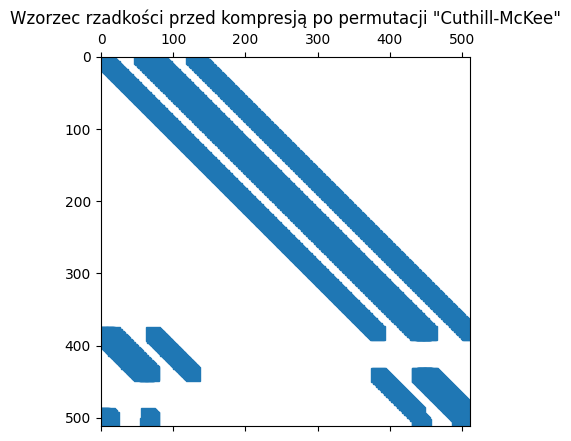

In [49]:
permutate_matrix_cmk = matrix[cuthill_mckee(matrix)]
plt.spy(permutate_matrix_cmk, markersize=10)
plt.title("Wzorzec rzadkości przed kompresją po permutacji \"Cuthill-McKee\"")
plt.show()

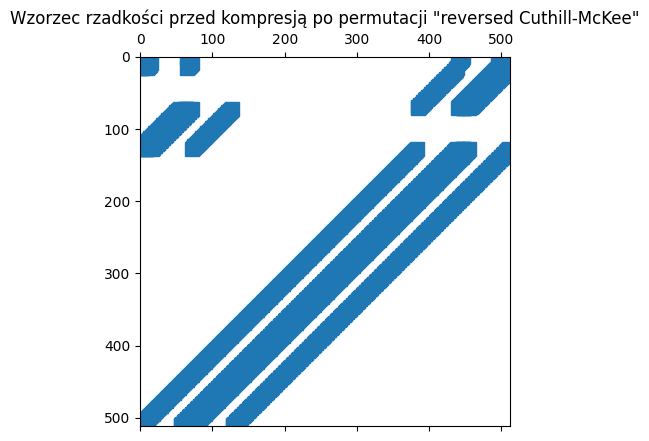

In [50]:
permutate_matrix_rcmk = matrix[reversed_cuthill_mckee(matrix)]
plt.spy(permutate_matrix_rcmk, markersize=10)
plt.title("Wzorzec rzadkości przed kompresją po permutacji \"reversed Cuthill-McKee\"")
plt.show()

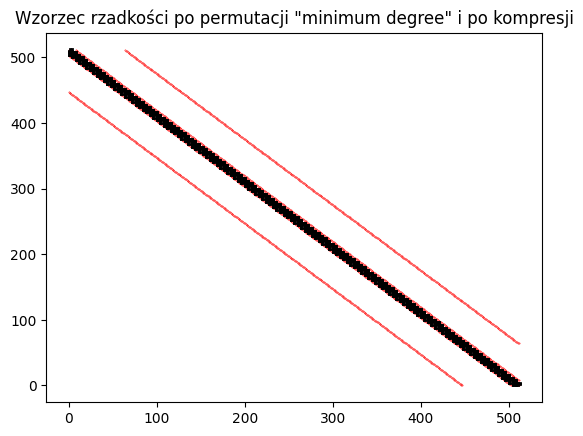

In [51]:
n = len(matrix)
tree = create_tree(permutate_matrix_md, 2, 10**-12)
wisualize_svd(tree, n)
plt.title("Wzorzec rzadkości po permutacji \"minimum degree\" i po kompresji")
plt.show()

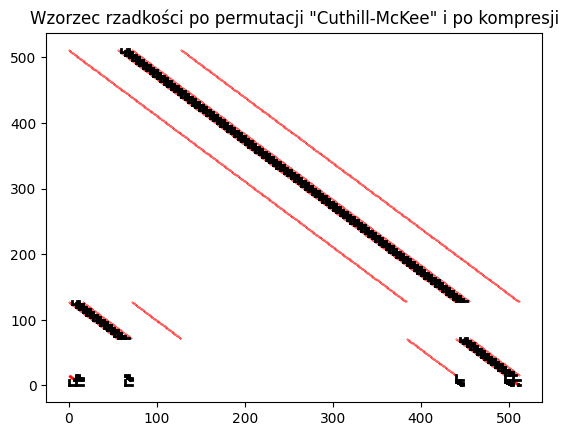

In [52]:
n = len(matrix)
tree = create_tree(permutate_matrix_cmk, 2, 10**-12)
wisualize_svd(tree, n)
plt.title("Wzorzec rzadkości po permutacji \"Cuthill-McKee\" i po kompresji")
plt.show()

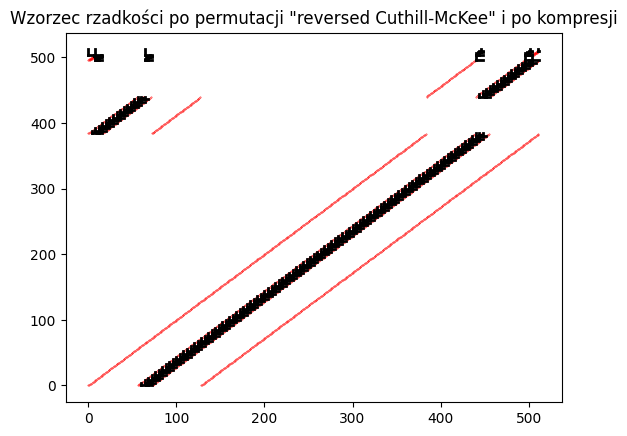

In [53]:
n = len(matrix)
tree = create_tree(permutate_matrix_rcmk, 2, 10**-12)
wisualize_svd(tree, n)
plt.title("Wzorzec rzadkości po permutacji \"reversed Cuthill-McKee\" i po kompresji")
plt.show()